In [ ]:
!git clone https://github.com/intelpro/Samsung_TAsession/
%cd /content/Samsung_TAsession/PSMnet/
!ls
!mkdir saved_model
from google.colab import drive
drive.mount('/content/gdrive/')
datapath = '/content/gdrive/My Drive/samsung_TAsession/KITTI_2015/training/'
savemodel = './saved_model'

## import로 모듈 가져오기
### torch에 있는 module, 우리가 사전에 정의해놓았던 함수 등 import로 가져온다. 

In [ ]:
from __future__ import print_function 
import torch 
import torch.nn as nn 
import torch.utils.data 
from torch.autograd import Variable 
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import time
from submodule import *
from preprocess import *
from dataloader import listflowfile as lt
from dataloader.KITTILoader import *
from dataloader.KITTIloader2015 import *

## Get dataset string
### data path 내에 있는 left image, right image, disparity 등의 string을 가져온다.

In [ ]:
all_left_img, all_right_img, all_left_disp, test_left_img, test_right_img, test_left_disp = dataloader(datapath)
print('left image string:', all_left_img[0])
print('right image string: ', all_right_img[0])
print('left disparity string: ', all_left_disp[0])
print('test left image string: ',test_left_img[0])
print('test right image string: ', test_right_img[0])

left image string: /content/gdrive/My Drive/samsung_TAsession/KITTI_2015/training/image_2/000198_10.png
right image string:  /content/gdrive/My Drive/samsung_TAsession/KITTI_2015/training/image_3/000198_10.png
left disparity string:  /content/gdrive/My Drive/samsung_TAsession/KITTI_2015/training/disp_occ_0/000198_10.png
test left image string:  /content/gdrive/My Drive/samsung_TAsession/KITTI_2015/training/image_2/000079_10.png
test right image string:  /content/gdrive/My Drive/samsung_TAsession/KITTI_2015/training/image_3/000079_10.png


## Define dataloader
### image string정보를 사용하여 dataloader를 정의한다. 

In [ ]:
KITTI_dataset_train = myImageFloder(all_left_img,all_right_img,all_left_disp, True)
TrainImgLoader = torch.utils.data.DataLoader(KITTI_dataset_train, 
      batch_size= 2, shuffle= True, num_workers= 8, drop_last=False)
print('Train object: ', TrainImgLoader)
KITTI_dataset_test = myImageFloder(test_left_img, test_right_img, test_left_disp, True)
TestImgLoader = torch.utils.data.DataLoader(KITTI_dataset_test, \
                batch_size=8, shuffle= False, num_workers= 4, drop_last=False)
print('Test object: ', TestImgLoader)

Train object:  <torch.utils.data.dataloader.DataLoader object at 0x7fca0c08da20>
Test object:  <torch.utils.data.dataloader.DataLoader object at 0x7fca0c08db38>


## Check KITTI dataset data
### 우리가 정의한 KITTI dataset 정보를 사용하여 image들을 plot 해봅니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


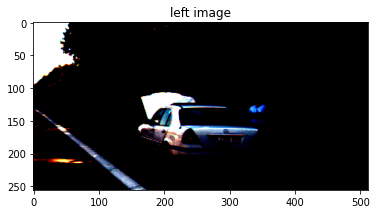

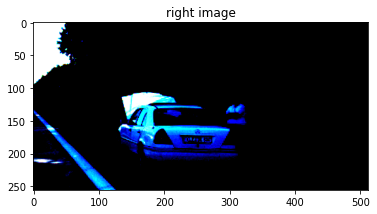

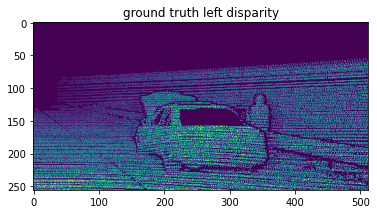

In [ ]:
left_img, right_img, left_disp = KITTI_dataset_train.__getitem__(0)
plt.figure()
plt.title('left image')
plt.imshow(left_img.detach().cpu().numpy().transpose(1,2,0))
plt.figure()
plt.title('right image')
plt.imshow(right_img.detach().cpu().numpy().transpose(1,2,0))
plt.figure()
plt.title('ground truth left disparity')
plt.imshow(left_disp)

## Feature extractor 정의하기 
### 이미지에 feature를 뽑는 함수를 정의해봅니다. 
### 그중에서도 우리가 구현할 것은 Spatial pyramid pooling module입니다. 

In [ ]:
def convbn(in_planes, out_planes, kernel_size, stride, pad, dilation):
    return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation = dilation, bias=False), \
                         nn.BatchNorm2d(out_planes))

class feature_extraction(nn.Module):
    def __init__(self):
        super(feature_extraction, self).__init__()
        self.inplanes = 32
        self.firstconv = nn.Sequential(convbn(3, 32, 3, 2, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True))

        self.layer1 = self._make_layer(BasicBlock, 32, 3, 1,1,1)
        self.layer2 = self._make_layer(BasicBlock, 64, 16, 2,1,1) 
        self.layer3 = self._make_layer(BasicBlock, 128, 3, 1,1,1)
        self.layer4 = self._make_layer(BasicBlock, 128, 3, 1,1,2)

        ## Your implementation Here
        self.branch1 = nn.Sequential(nn.AvgPool2d((None, None), stride=(None,None)),
                                     convbn(None, None, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch2 = nn.Sequential(nn.AvgPool2d((None, None), stride=(None,None)),
                                     convbn(None, None, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch3 = nn.Sequential(nn.AvgPool2d((None, None), stride=(None,None)),
                                     convbn(None, None, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch4 = nn.Sequential(nn.AvgPool2d((None, None), stride=(None,None)),
                                     convbn(None, None, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))
        ## Your implementation end        

        self.lastconv = nn.Sequential(convbn(320, 128, 3, 1, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, kernel_size=1, padding=0, stride = 1, bias=False))

    def _make_layer(self, block, planes, blocks, stride, pad, dilation):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
           downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, pad, dilation))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,1,None,pad,dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        output      = self.firstconv(x)
        output      = self.layer1(output)
        output_raw  = self.layer2(output)
        output      = self.layer3(output_raw)
        output_skip = self.layer4(output)


        output_branch1 = self.branch1(output_skip)
        output_branch1 = F.upsample(output_branch1, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch2 = self.branch2(output_skip)
        output_branch2 = F.upsample(output_branch2, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch3 = self.branch3(output_skip)
        output_branch3 = F.upsample(output_branch3, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch4 = self.branch4(output_skip)
        output_branch4 = F.upsample(output_branch4, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_feature = torch.cat((output_raw, output_skip, output_branch4, output_branch3, output_branch2, output_branch1), 1)
        output_feature = self.lastconv(output_feature)

        return output_feature

## PSMnet
### PSMnet 생성자 정의하기
#### 1단계: feature extraction part 정의하기
#### 2단계: 3D convolution part 정의하기
#### 3단계: weight initialization 하기
### PSMnet forward 함수 정의하기
#### 1단계: left, right 이미지에서 feature extraction을 수행한다. 
#### 2단계: cost volume을 만든다.  + left, right feature map을 cost volume의 형태에 맞게 만들어준다
#### 3단계: 3D convolution을 통해서 cost volume의 refinement를 수행한다. 
#### 4단계: disparity regression을 수행한다.

In [ ]:
class PSMNet(nn.Module):
    def __init__(self, maxdisp):
        super(PSMNet, self).__init__()
        self.maxdisp = maxdisp

        self.feature_extraction = feature_extraction()

        self.dres0 = nn.Sequential(convbn_3d(64, 32, 3, 1, 1),
                                     nn.ReLU(inplace=True),
                                     convbn_3d(32, 32, 3, 1, 1),
                                     nn.ReLU(inplace=True))

        self.dres1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 

        self.dres2 = hourglass(32)
        self.dres3 = hourglass(32)
        self.dres4 = hourglass(32)

        self.classif1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif2 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif3 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()


    def forward(self, left, right):

        refimg_fea     = self.feature_extraction(left)
        targetimg_fea  = self.feature_extraction(right)


        #matching
        cost = Variable(torch.FloatTensor(refimg_fea.size()[0], refimg_fea.size()[1]*2, self.maxdisp//4,  refimg_fea.size()[2],  refimg_fea.size()[3]).zero_()).cuda()

        for i in range(self.maxdisp//4):
            if i > 0 :
             cost[:, :refimg_fea.size()[1], i, :,i:]   = refimg_fea[:,:,:,i:]
             cost[:, refimg_fea.size()[1]:, i, :,i:] = targetimg_fea[:,:,:,:-i]
            else:
             cost[:, :refimg_fea.size()[1], i, :,:]   = refimg_fea
             cost[:, refimg_fea.size()[1]:, i, :,:]   = targetimg_fea
        cost = cost.contiguous()

        cost0 = self.dres0(cost)
        cost0 = self.dres1(cost0) + cost0

        out1, pre1, post1 = self.dres2(cost0, None, None) 
        out1 = out1+cost0

        out2, pre2, post2 = self.dres3(out1, pre1, post1) 
        out2 = out2+cost0

        out3, pre3, post3 = self.dres4(out2, pre1, post2) 
        out3 = out3+cost0

        cost1 = self.classif1(out1)
        cost2 = self.classif2(out2) + cost1
        cost3 = self.classif3(out3) + cost2
        if self.training:
          cost1 = F.upsample(cost1, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
          cost2 = F.upsample(cost2, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')

          cost1 = torch.squeeze(cost1,1)
          pred1 = F.softmax(cost1,dim=1)
          pred1 = disparityregression(self.maxdisp)(pred1)

          cost2 = torch.squeeze(cost2,1)
          pred2 = F.softmax(cost2,dim=1)
          pred2 = disparityregression(self.maxdisp)(pred2)

        cost3 = F.upsample(cost3, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
        cost3 = torch.squeeze(cost3,1)
        pred3 = F.softmax(cost3,dim=1)
        #For your information: This formulation 'softmax(c)' learned "similarity" 
        #while 'softmax(-c)' learned 'matching cost' as mentioned in the paper.
        #However, 'c' or '-c' do not affect the performance because feature-based cost volume provided flexibility.
        pred3 = disparityregression(self.maxdisp)(pred3)

        if self.training:
            return pred1, pred2, pred3
        else:
            return pred3        

## main 함수
### 각종 hyperparameter들과 dataset 경로들을 지정한다. 
### model을 정의하고 gpu상에 올려준다. 
### optimizer를 정의한다. 
### model을 print하면 우리가 정의했던 model들의 module들을 볼 수 있다. 

In [ ]:
if __name__=='__main__':
    max_disp = 192
    epochs = 1
    model = PSMNet(max_disp)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    print(model.feature_extraction)

## Training with KITT dataset
### 3 epoch동안 트레이닝을 수행합니다. 
### loss function으로는 smoothness L1 loss를 사용합니다.
### training log를 보며 정상적으로 training loss가 줄어드는 것을 확인하세요. 

In [ ]:
    for epoch in range(0, epochs):
        total_train_loss = 0
        print('This is %d-th epoch' %(epoch))
        model.train()
        #------------- Train ------------------------------------------------------------
        for batch_idx, (imgL_crop, imgR_crop, disp_crop_L) in enumerate(TrainImgLoader):
            imgL_crop, imgR_crop, disp_crop_L = imgL_crop.cuda(), imgR_crop.cuda(), disp_crop_L.cuda()
            mask = disp_crop_L < max_disp
            mask.detach_()
            start_time = time.time()
            output = model(imgL_crop, imgR_crop)
            loss = F.smooth_l1_loss(output[0][mask], disp_crop_L[mask], size_average=True)
            loss.backward()
            total_train_loss += loss.detach().item()
            optimizer.step()
            if batch_idx % 3 == 0:
                print('Iter %d training loss = %.3f , time = %.2f' %(batch_idx, loss, time.time() - start_time))
        print('epoch %d total training loss = %.3f' %(epoch, total_train_loss/len(TrainImgLoader)))
        #SAVE
        savefilename = savemodel+'/checkpoint_'+str(epoch)+'.tar'
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'train_loss': total_train_loss/len(TrainImgLoader),
         }, savefilename)
        #------------- TEST ------------------------------------------------------------
        total_test_loss = 0
        for batch_idx, (imgL, imgR, disp_L) in enumerate(TestImgLoader):
            test_loss, disp = test(model, imgL,imgR, disp_L)
            print('Iter %d test loss = %.3f' %(batch_idx, test_loss))
            total_test_loss += test_loss
        print('total test loss = %.3f' %(total_test_loss/len(TestImgLoader)))

## Test with KITTI test sample 
### Test set의 데이터를 사용하여 disparity 이미지를 출력해봅시다.
### 트레이닝에 시간이 오래걸림으로 pretrianed model을 사용합니다. 

In [ ]:
left_image_path = '/content/gdrive/My Drive/samsung_TAsession/KITTI_2015/testing/left.png'
right_image_path = '/content/gdrive/My Drive/samsung_TAsession/KITTI_2015/testing/right.png'

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


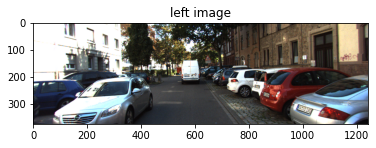

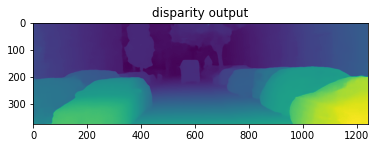

time = 2.68


In [ ]:
  def test_img(imgL,imgR):
      model.eval()

      imgL = imgL.cuda()
      imgR = imgR.cuda()     

      with torch.no_grad():
          disp = model(imgL,imgR)

      disp = torch.squeeze(disp)
      pred_disp = disp.data.cpu().numpy()

      return pred_disp
if __name__=='__main__':
    from collections import OrderedDict
    checkpoint = torch.load('/content/gdrive/My Drive/samsung_TAsession/pretrained_model_KITTI2015.tar')
    new_state_dict = OrderedDict()
    for k, v in checkpoint['state_dict'].items():
        name = k[7:]
        new_state_dict[name] = v    
    model.load_state_dict(new_state_dict)    
    normal_mean_var = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}
    infer_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(**normal_mean_var)])    

    imgL_o = Image.open(left_image_path).convert('RGB')
    imgR_o = Image.open(right_image_path).convert('RGB')

    imgL = infer_transform(imgL_o)
    imgR = infer_transform(imgR_o) 

    # pad to width and hight to 16 times
    if imgL.shape[1] % 16 != 0:
        times = imgL.shape[1]//16       
        top_pad = (times+1)*16 -imgL.shape[1]
    else:
        top_pad = 0

    if imgL.shape[2] % 16 != 0:
        times = imgL.shape[2]//16                       
        right_pad = (times+1)*16-imgL.shape[2]
    else:
        right_pad = 0    

    imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
    imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)

    start_time = time.time()
    pred_disp = test_img(imgL,imgR)
    if top_pad !=0 or right_pad != 0:
      img = pred_disp[top_pad:,:-right_pad]
    else:
      img = pred_disp
    plt.figure()
    plt.title('left image')
    plt.imshow(imgL_o)
    plt.figure()
    plt.title('disparity output')
    plt.imshow(img)
    plt.show()
    print('time = %.2f' %(time.time() - start_time))